In [16]:
import os

DATA_PATH = "/Users/walazerelli/tac-25-26/data/camille_Crise_economique_Belgique.txt"


documents = []

for f in os.listdir(DATA_PATH):
    if f.endswith(".txt"):
        documents.append(os.path.join(DATA_PATH, f))

print("Chargement du corpus terminé")
print("Nombre de documents :", len(documents))



Chargement du corpus terminé
Nombre de documents : 935


In [17]:
import re

def normalize_text(s):
    s = s.lower()
    s = re.sub(r"\d+", " ", s)
    s = re.sub(r"[^\wàâéèêëîïôûùüçœæ\s]", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

textes_nettoyes = []

for path in documents:
    with open(path, encoding="utf-8", errors="ignore") as file:
        texte = file.read()
        textes_nettoyes.append(normalize_text(texte))

print("Nettoyage terminé")
print("Nombre de documents nettoyés :", len(textes_nettoyes))




Nettoyage terminé
Nombre de documents nettoyés : 935


In [18]:
texte_global = " ".join(textes_nettoyes)

print("Texte global prêt pour analyse")
print("Longueur du texte global :", len(texte_global))


Texte global prêt pour analyse
Longueur du texte global : 23689949


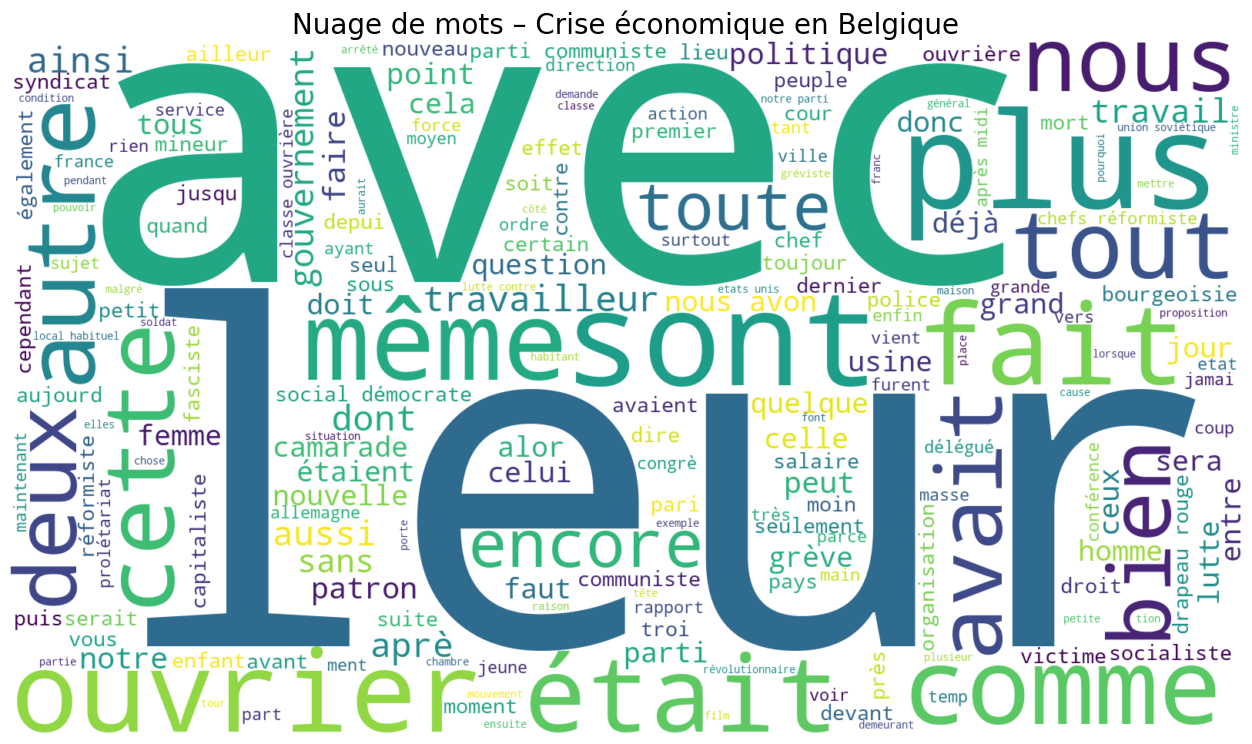

In [19]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

STOPWORDS_WC = {
    "de","la","le","les","un","une","et","en","du","des","pour","que","qui",
    "dans","au","aux","par","sur","se","ne","pas","ce","ces","mais","ou","a",
    "il","elle","avoir","être",
    "crise","économique","economique",
    "belgique","belge","journal","article"
}

wc = WordCloud(
    width=1600,
    height=900,
    background_color="white",
    stopwords=STOPWORDS_WC,
    colormap="viridis",
    min_word_length=4
).generate(texte_global)

plt.figure(figsize=(16,9))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title("Nuage de mots – Crise économique en Belgique", fontsize=20)
plt.show()








In [4]:
# ===== EXTRACTION DE MOTS-CLÉS (YAKE) – TP4 =====

import pandas as pd
import yake

def extract_keywords_yake(docs, topk=200, max_ngram=3):
    """
    Extraction de mots-clés avec YAKE sur l'ensemble du sous-corpus.
    """
    extractor = yake.KeywordExtractor(lan="fr", n=max_ngram, top=topk)
    joined = "\n".join(docs)
    keywords = extractor.extract_keywords(joined)
    return pd.DataFrame(keywords, columns=["keyword", "score"]).sort_values("score")


def clean_keywords(df, stopset):
    """
    Nettoyage des mots-clés :
    - normalisation
    - suppression des stopwords génériques et contextuels
    - suppression des doublons
    """
    cleaned = []
    seen = set()

    for kw, score in df.values:
        k = " ".join(
            w for w in normalize_text(kw).split()
            if w not in stopset and len(w) > 2
        )
        if not k or k in seen:
            continue
        seen.add(k)
        cleaned.append((k, score))

    return pd.DataFrame(cleaned, columns=["keyword", "score"]).sort_values("score")


# Stopwords renforcés (correction explicite TP2 → TP4)
STOPWORDS_CONTEXT = {
    "rue","avenue","place","maison","ville","tél","tel",
    "article","journal","soir",
    "belgique","belge","année",
    "crise","économique","economique",
    "dit","déclare","fait","faire","avoir","être"
}

# Extraction + nettoyage
kw_df_raw = extract_keywords_yake(texts)
kw_df_clean = clean_keywords(kw_df_raw, STOPWORDS_CONTEXT)

# Affichage
kw_df_clean.head(10)



,keyword,score
0,marqué,0.009760
1,profondément marqué,0.027581
2,chômage explosé,0.140057
3,profondément,0.163833
4,entreprises ont fermé,0.196132
5,panique financière,0.239561
6,explosé,0.303385
7,journaux époque,0.329526
8,époque relatent,0.329526
9,relatent panique,0.329526


In [2]:
# ===== NER OPTIMISÉ (PERSON / ORG / GPE) – TP4 =====

import os
import re
import pandas as pd
import spacy

DATA_PATH = "/Users/walazerelli/tac-25-26/data/camille_Crise_economique_Belgique.txt"
CHUNK_SIZE = 100_000

nlp = spacy.load(
    "fr_core_news_md",
    disable=["tagger", "parser", "lemmatizer", "morphologizer"]
)
nlp.max_length = 5_000_000

ENT_STOP = {
    "dem","bur","adr","fem","mén","ec","av","tel","tél","ag",
    "mm","mr","mme","m","s","st","bd","n°","no",
    "rue","avenue","place","bureau",
    "rossel","agence rossel"
}

def normalize_text(s):
    s = s.lower()
    s = re.sub(r"\d+", " ", s)
    s = re.sub(r"[^\wàâéèêëîïôûùüçœæ\s]", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

def clean_entity(ent):
    ent = ent.strip()
    ent = re.sub(r"\s+", " ", ent)
    ent = re.sub(r"^[^\w]+|[^\w]+$", "", ent)
    return ent

entities = []

for f in os.listdir(DATA_PATH):
    if f.endswith(".txt"):
        with open(os.path.join(DATA_PATH, f),
                  encoding="utf-8", errors="ignore") as file:
            text = normalize_text(file.read())

        for i in range(0, len(text), CHUNK_SIZE):
            chunk = text[i:i + CHUNK_SIZE]
            doc = nlp(chunk)
            for ent in doc.ents:
                if ent.label_ in ("PERSON", "ORG", "GPE"):
                    e = clean_entity(ent.text)
                    if len(e) >= 3 and e.lower() not in ENT_STOP:
                        entities.append((e, ent.label_))

ner_df = pd.DataFrame(entities, columns=["entite", "type"])

# ===== CONTRÔLE DES TYPES D’ENTITÉS (TP4) =====

print("Répartition des entités reconnues :")
ner_df["type"].value_counts()

top_entities = (
    ner_df
    .groupby(["type", "entite"])
    .size()
    .reset_index(name="frequence")
    .sort_values(["type", "frequence"], ascending=[True, False])
)

top20_entities = top_entities.groupby("type").head(20)
print(top20_entities)

print(f"Nombre total d'entités extraites : {len(ner_df)}")
print(f"Nombre d'entités uniques : {ner_df['entite'].nunique()}")








A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.3.4 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/Users/walazerelli/tac-25-26/env311/lib/python3.11/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/Users/walazerelli/tac-25-26/env311/lib/python3.11/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "/Users/walazerelli/tac-25-26/env311/lib/python3.11/site-packages/ipykernel/kernelapp.py", line 758, in start
    s

Répartition des entités reconnues :
      type                  entite  frequence
7212   ORG  parti communiste belge        111
8051   ORG                   reich         95
10066  ORG             yougoslavie         67
9267   ORG                     u e         61
5335   ORG              kuomintang         60
2617   ORG                     eit         43
4443   ORG                     iit         41
4951   ORG                     jes         41
9438   ORG                     unc         41
5363   ORG      l union soviétique         40
1519   ORG               cockerill         35
9084   ORG                     tou         29
6597   ORG                     nou         28
7032   ORG                     ous         28
3364   ORG             front rouge         27
8933   ORG                     ter         27
2076   ORG                     deg         26
1701   ORG             congo belge         24
7751   ORG                     pre         23
4405   ORG                     iie         2

In [ ]:


import os
import re
import pandas as pd
from textblob import TextBlob
import spacy

DATA_PATH = "/Users/walazerelli/tac-25-26/data/camille_Crise_economique_Belgique.txt"

nlp = spacy.load(
    "fr_core_news_md",
    disable=["ner", "tagger", "parser", "lemmatizer", "morphologizer"]
)
nlp.add_pipe("sentencizer")  # ← FIX IMPORTANT
nlp.max_length = 5_000_000

def normalize_text(s):
    s = s.lower()
    s = re.sub(r"\d+", " ", s)
    s = re.sub(r"[^\wàâéèêëîïôûùüçœæ\s]", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

sentences = []

for f in os.listdir(DATA_PATH):
    if f.endswith(".txt"):
        with open(os.path.join(DATA_PATH, f),
                  encoding="utf-8", errors="ignore") as file:
            text = file.read()
            doc = nlp(text)
            for s in doc.sents:
                sent = s.text.strip()
                if len(sent) > 30:
                    sentences.append(sent)

print(f"Nombre total de phrases extraites : {len(sentences)}")

# Limitation pour éviter biais de volume
sentences = sentences[:500]

rows = []
for s in sentences:
    blob = TextBlob(s)
    pol, subj = blob.sentiment
    rows.append({
        "phrase": s,
        "polarite": float(pol),
        "subjectivite": float(subj)
    })

sent_df = pd.DataFrame(rows)

print("\nRésumé statistique du sentiment :")
print(sent_df[["polarite", "subjectivite"]].describe())

sent_df.head(10)



Nombre total de phrases extraites : 194379

Résumé statistique du sentiment :
         polarite  subjectivite
count  500.000000    500.000000
mean     0.018258      0.067536
std      0.138386      0.223739
min     -0.800000      0.000000
25%      0.000000      0.000000
50%      0.000000      0.000000
75%      0.000000      0.000000
max      1.000000      1.000000


,phrase,polarite,subjectivite
0,nr OKAriàA u uuimi Nouvelles Internationales L...,0.000,0.000
1,"En même temps, 200 citoyena de l'Union soviéti...",0.000,0.000
2,"Le directeur du chemin de fer, Iemchanov, son ...",0.000,0.000
3,Les autorités chinoises ont fermé toutes les i...,-0.050,0.400
4,Ces faits sont la preuve éclatante que le gouv...,0.000,0.000
5,"Hsue Liang, d'accord avec les gardes-blancs ru...",0.000,0.000
6,"A propos de oes diernières affaires, les ouvri...",0.000,0.000
7,"R. s. S. AMI DU PEUPLE CHINOIS Dès 1919, le go...",-0.800,1.000
8,Les accords préliminaires et le projet de trai...,0.000,0.000
9,"A partir de ce moment, les peuples de Chine on...",-0.125,0.375


In [4]:


from pathlib import Path
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
import multiprocessing
import nltk
from nltk.corpus import stopwords

# Téléchargement des stopwords français
nltk.download('stopwords', quiet=True)
french_stopwords = stopwords.words('french')

# Style des graphiques
plt.style.use("seaborn-v0_8")

print("=" * 70)
print("TP4 : Clustering et Word2Vec - Traitement automatique de corpus")
print("=" * 70)

TP4 : Clustering et Word2Vec - Traitement automatique de corpus


In [7]:

CORPUS_PATH = Path("/Users/walazerelli/tac-25-26/data/camille_Crise_economique_Belgique.txt")

def load_documents(path=CORPUS_PATH):
    rows = []
    for p in path.rglob("*.txt"):
        try:
            text = p.read_text(encoding="utf-8")
        except:
            text = p.read_text(encoding="latin-1")
        year_search = re.search(r"(18|19|20)\d{2}", p.stem)
        year = int(year_search.group(0)) if year_search else 0
        rows.append({"id": p.stem, "year": year, "text": text})
    df = pd.DataFrame(rows)
    df["year"] = df["year"].fillna(0).astype(int)
    return df

df = load_documents()
print(f"\n✅ Nombre total de documents chargés : {len(df)}")

# Choix de la décennie
DECADE = (1929,1929)
start, end = DECADE
df_dec = df[(df["year"] >= start) & (df["year"] <= end)].copy()
print(f"✅ Décennie sélectionnée : {start}-{end}")
print(f"✅ Nombre de documents dans cette décennie : {len(df_dec)}")


✅ Nombre total de documents chargés : 935
✅ Décennie sélectionnée : 1929-1929
✅ Nombre de documents dans cette décennie : 934


In [8]:

def preprocess(text):
    """Nettoie et normalise le texte"""
    text = text.lower()
    text = re.sub(r"\d+", " ", text)
    text = re.sub(r"[^a-zàâéèêëîïôûùüçœæ\s-]", " ", text)
    text = re.sub(r"\s+", " ", text)
    return text.strip()

df_dec["clean"] = df_dec["text"].astype(str).apply(preprocess)
print("\n✅ Prétraitement terminé")
print("\nAperçu des textes nettoyés :")
print(df_dec["clean"].head(2))


✅ Prétraitement terminé

Aperçu des textes nettoyés :
0    nr okariàa u uuimi nouvelles internationales l...
1    oëb msm le ltaï tesiri t ï m n chmique du twpw...
Name: clean, dtype: object



CLUSTERING DES DOCUMENTS

✅ Matrice TF-IDF créée : (934, 20000)
   → 934 documents
   → 20000 termes uniques

📊 Test de différents nombres de clusters...


/Users/walazerelli/tac-25-26/env311/lib/python3.11/site-packages/threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


   K=3 : Silhouette = 0.024
   K=4 : Silhouette = 0.027
   K=5 : Silhouette = 0.026
   K=6 : Silhouette = 0.020
   K=7 : Silhouette = 0.019
   K=8 : Silhouette = 0.022
   K=9 : Silhouette = 0.017


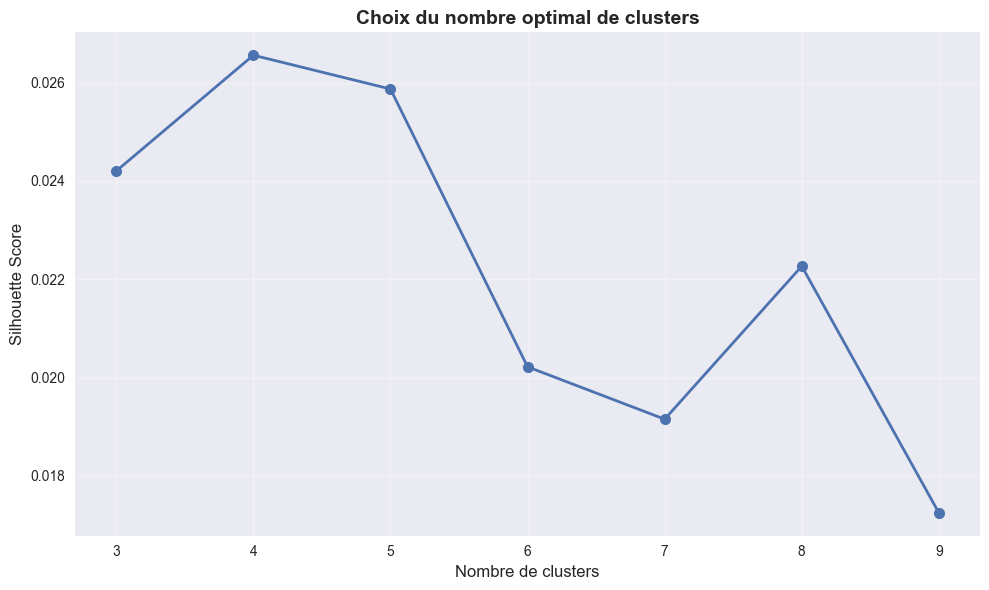

In [9]:

MAX_FEATURES = 20000
MIN_DF = 5
RANDOM_STATE = 42

print("\n" + "=" * 70)
print("CLUSTERING DES DOCUMENTS")
print("=" * 70)

tfidf = TfidfVectorizer(
    max_features=MAX_FEATURES, 
    min_df=MIN_DF, 
    stop_words=french_stopwords
)
X = tfidf.fit_transform(df_dec["clean"])
print(f"\n✅ Matrice TF-IDF créée : {X.shape}")
print(f"   → {X.shape[0]} documents")
print(f"   → {X.shape[1]} termes uniques")

# ===== TEST DU NOMBRE OPTIMAL DE CLUSTERS =====
print("\n📊 Test de différents nombres de clusters...")
silhouette_scores = []
K_range = range(3, 10)

for k in K_range:
    km_temp = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=20)
    labels_temp = km_temp.fit_predict(X)
    sil_temp = silhouette_score(X, labels_temp)
    silhouette_scores.append(sil_temp)
    print(f"   K={k} : Silhouette = {sil_temp:.3f}")

# Visualisation
plt.figure(figsize=(10, 6))
plt.plot(K_range, silhouette_scores, marker='o', linewidth=2, markersize=8)
plt.xlabel("Nombre de clusters", fontsize=12)
plt.ylabel("Silhouette Score", fontsize=12)
plt.title("Choix du nombre optimal de clusters", fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [10]:

N_CLUSTERS = 6

kmeans = KMeans(n_clusters=N_CLUSTERS, random_state=RANDOM_STATE, n_init=20)
labels = kmeans.fit_predict(X)
df_dec["cluster"] = labels
sil = silhouette_score(X, labels)

print(f"\n✅ Modèle final avec K={N_CLUSTERS}")
print(f"✅ Silhouette Score : {sil:.3f}")


cluster_info = df_dec.groupby("cluster").agg({
    "id": "count",
    "year": ["min", "max", "mean"]
}).round(1)
cluster_info.columns = ["Nb_docs", "Année_min", "Année_max", "Année_moy"]

print("\n" + "=" * 70)
print("DISTRIBUTION DES CLUSTERS")
print("=" * 70)
print(cluster_info)

# Sauvegarde
output_path = Path("/Users/walazerelli/tac-25-26/data/camille_Crise_economique_Belgique.txt")
output_path.mkdir(exist_ok=True)
cluster_info.to_csv(output_path / "cluster_stats.csv")
print(f"\n✅ Statistiques sauvegardées : {output_path / 'cluster_stats.csv'}")


✅ Modèle final avec K=6
✅ Silhouette Score : 0.020

DISTRIBUTION DES CLUSTERS
         Nb_docs  Année_min  Année_max  Année_moy
cluster                                          
0            200       1929       1929     1929.0
1            146       1929       1929     1929.0
2            293       1929       1929     1929.0
3             43       1929       1929     1929.0
4            211       1929       1929     1929.0
5             41       1929       1929     1929.0

✅ Statistiques sauvegardées : /Users/walazerelli/tac-25-26/data/camille_Crise_economique_Belgique.txt/cluster_stats.csv


In [11]:
print("\n" + "=" * 70)
print("TOP TERMES PAR CLUSTER")
print("=" * 70)

terms = tfidf.get_feature_names_out()
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]

top_terms = {}
for i in range(N_CLUSTERS):
    top = [terms[idx] for idx in order_centroids[i, :20]]
    top_terms[i] = top
    print(f"\n🔹 Cluster {i} ({len(df_dec[df_dec['cluster']==i])} documents) :")
    print("   " + ", ".join(top[:15]))



TOP TERMES PAR CLUSTER

🔹 Cluster 0 (200 documents) :
   ouvriers, plus, contre, cette, do, patrons, grève, travailleurs, réformistes, lutte, fait, mineurs, travail, salaires, tout

🔹 Cluster 1 (146 documents) :
   rayon, heures, local, rue, plus, bruxelles, tous, federation, do, habituel, radio, fr, prix, dimanche, concert

🔹 Cluster 2 (293 documents) :
   plus, do, contre, parti, ouvriers, cette, travailleurs, tout, fait, tous, comme, travail, guerre, lutte, leurs

🔹 Cluster 3 (43 documents) :
   sport, classement, pts, mètres, jeux, van, bat, rayon, bruxelles, heures, club, local, points, km, daring

🔹 Cluster 4 (211 documents) :
   do, plus, contre, ans, gouvernement, cette, deux, auto, comme, tout, rue, lo, où, après, demeurant

🔹 Cluster 5 (41 documents) :
   film, films, cinéma, rayon, heures, local, radio, plus, bruxelles, do, federation, habituel, rue, sonore, parlant


In [12]:

print("\n" + "=" * 70)
print("EXEMPLES DE DOCUMENTS PAR CLUSTER")
print("=" * 70)

for c in range(N_CLUSTERS):
    nb_docs = len(df_dec[df_dec['cluster']==c])
    print(f"\n--- Cluster {c} ({nb_docs} documents) ---")
    sample_docs = df_dec[df_dec["cluster"] == c].head(3)
    for idx, row in sample_docs.iterrows():
        preview = row["text"][:200].replace("\n", " ")
        print(f"  • [{row['id']}] {preview}...")


EXEMPLES DE DOCUMENTS PAR CLUSTER

--- Cluster 0 (200 documents) ---
  • [KB_JB1051_1929-09-08_01-00001] JBT. 250-251. ■mi •rittttBM SO fsek^frm^n Te hhsh^to BftlIillWHB 8 Ï? LTODI 9 SïPTBMBRE 19». J.PMLOl.J TELEPHONES : Administration ". 163.33 Publicité 163.33 Rédaction 163.33 Rédaction Après 19 heures...
  • [KB_JB1051_1929-08-17_01-00002] Ptf^Sf m ses .."■ ' • ■ :"•" i- LE DRAPEAU ROUGI! OHEZ LES MTKEURS DE ^ MARCHIElTNE-i Bas lus masques ... !■»■■ — LSS CALOMNIATEURS IN SERONT POUR LEURS FRAIS Le « Journal do Charleroi » a pùblii un a...
  • [KB_JB1051_1929-12-28_01-00003] amedi 28 Décembre 1929. « LE D'RAPEAU ROUGE » Souscription tour la défense du parti et de sa presse Certaine presse a repris avec un malin plai- r nos appels pressants r. la récolte et à l'en- I imméd...

--- Cluster 1 (146 documents) ---
  • [KB_JB1051_1929-06-09_01-00004] OËB msm LE^ltAÏ«teSiri«)T70ï ■M— — ■n—— Chmique du Twpwws -_.> .' : DESESPOIR Si nous voulons nous en rapporter aux quelquies aitioles d'Em


📊 Génération des wordclouds...


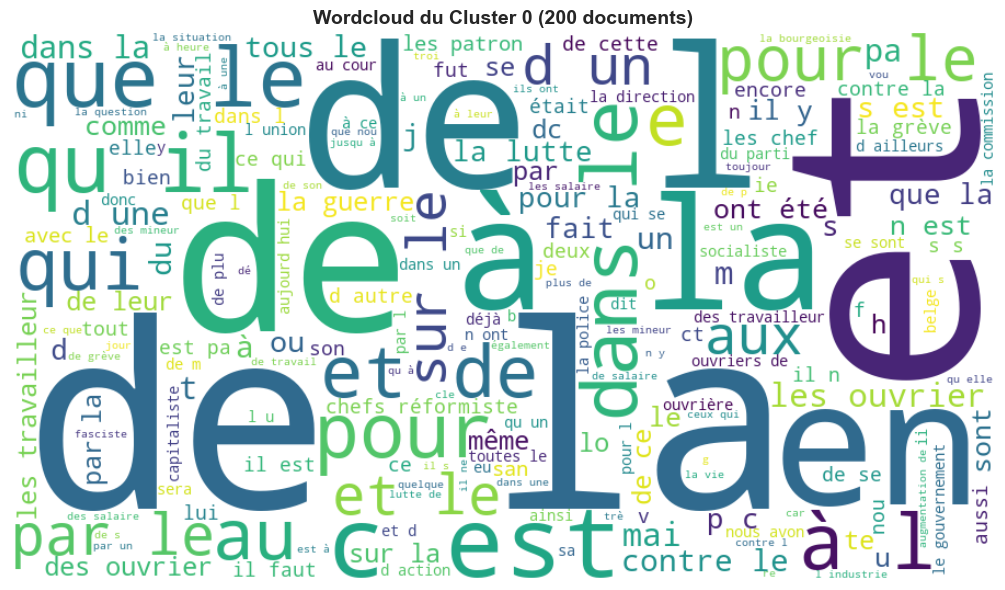

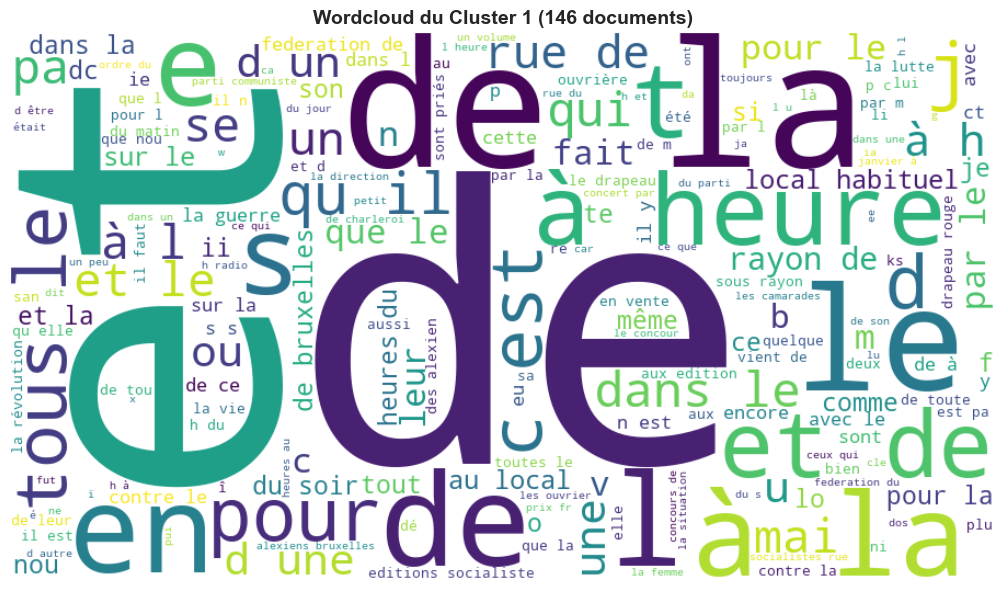

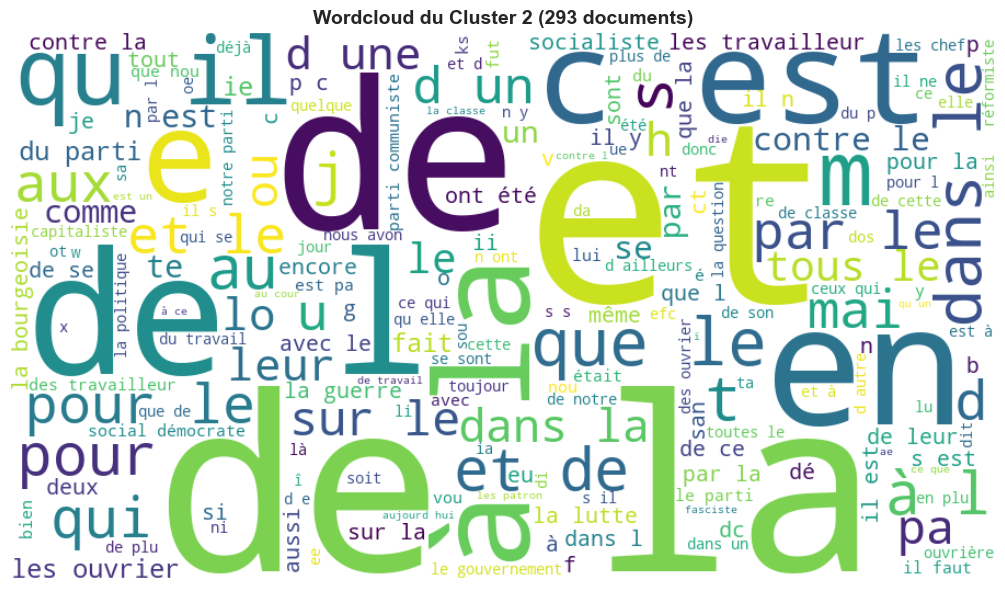

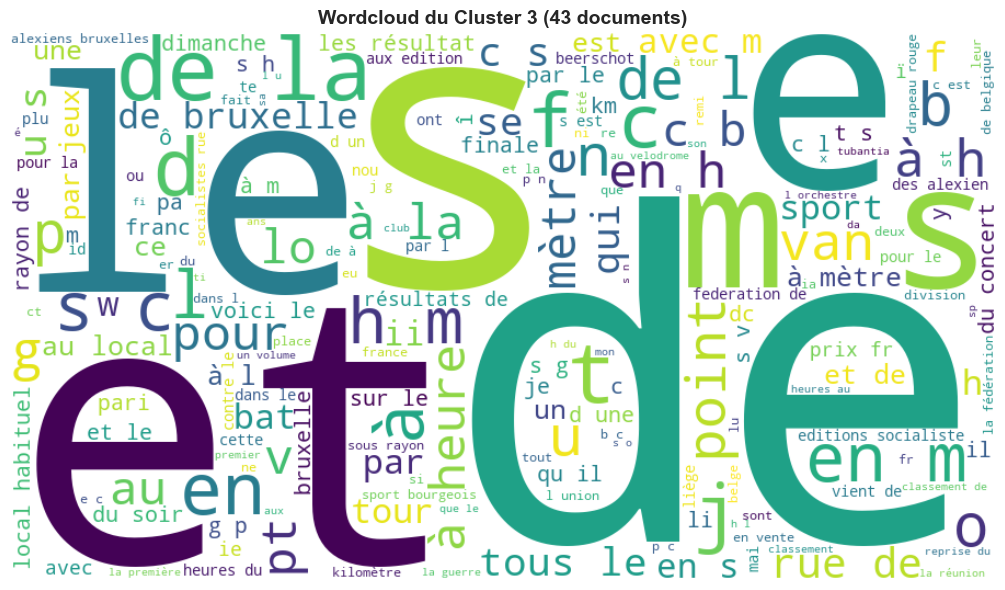

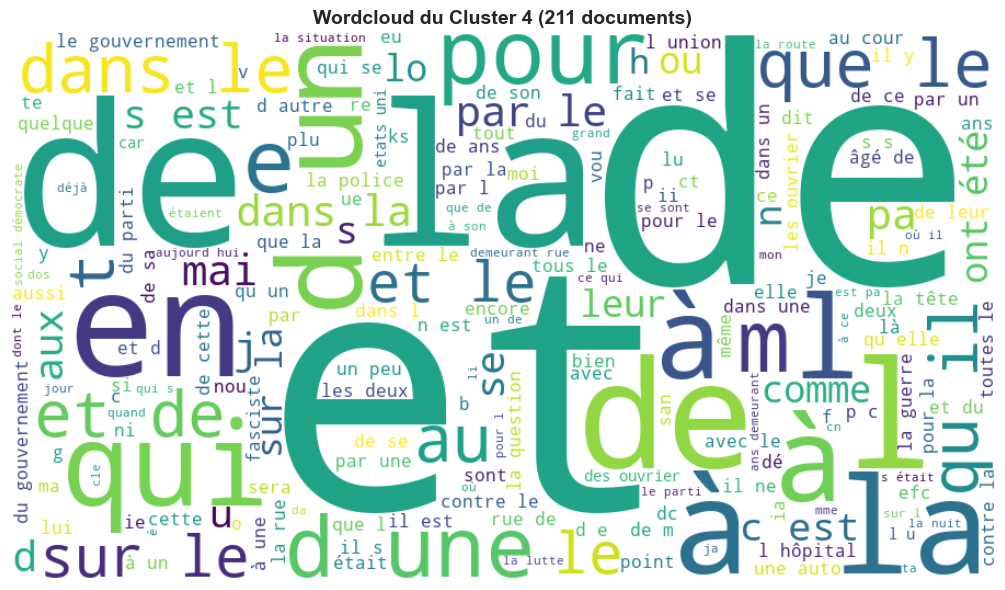

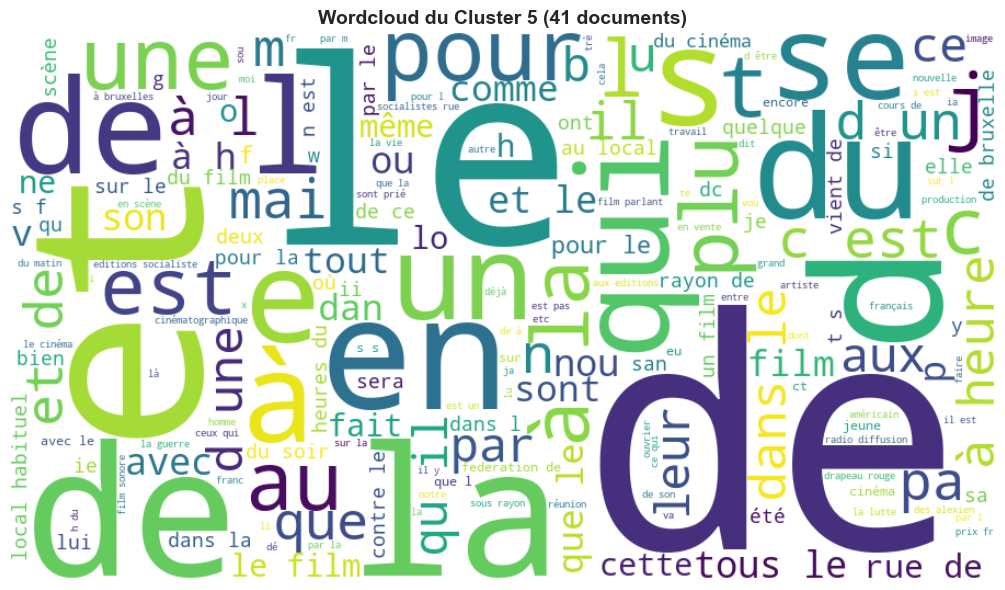


✅ Wordclouds générés


In [15]:
print("\n📊 Génération des wordclouds...")

for c in range(N_CLUSTERS):
    subset = " ".join(df_dec[df_dec["cluster"] == c]["clean"])
    if not subset.strip():
        print(f"⚠️  Cluster {c} : pas de texte disponible")
        continue
    
    wc = WordCloud(
        width=900, 
        height=500, 
        background_color="white",
        colormap="viridis"
    ).generate(subset)
    
    plt.figure(figsize=(12, 6))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Wordcloud du Cluster {c} ({len(df_dec[df_dec['cluster']==c])} documents)", 
              fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

print("\n✅ Wordclouds générés")


In [19]:
from pathlib import Path
from gensim.utils import simple_preprocess

SENTS_PATH = Path("/Users/walazerelli/tac-25-26/data/camille_Crise_economique_Belgique.txt")

sentences = []

# CAS 1 : dossier contenant des .txt
if SENTS_PATH.is_dir():
    for file in SENTS_PATH.glob("*.txt"):
        with open(file, "r", encoding="utf-8", errors="ignore") as f:
            for line in f:
                tokens = simple_preprocess(line.strip(), deacc=True)
                if tokens:
                    sentences.append(tokens)

# CAS 2 : fichier texte unique
elif SENTS_PATH.is_file():
    with open(SENTS_PATH, "r", encoding="utf-8", errors="ignore") as f:
        for line in f:
            tokens = simple_preprocess(line.strip(), deacc=True)
            if tokens:
                sentences.append(tokens)

else:
    raise FileNotFoundError(f"❌ Chemin invalide : {SENTS_PATH}")

print(f"\n✅ Nombre de phrases utilisables : {len(sentences)}")
print(f"✅ Exemple de phrase tokenisée : {sentences[0][:10]}...")




✅ Nombre de phrases utilisables : 964
✅ Exemple de phrase tokenisée : ['nr', 'okariaa', 'uuimi', 'nouvelles', 'internationales', 'agression', 'aatisovietiqae', 'en', 'mandchourie', 'le']...


In [20]:

W2V_SIZE = 200
W2V_WORKERS = max(1, multiprocessing.cpu_count() - 1)
RANDOM_STATE = 42

print("\n📊 Test de différentes configurations Word2Vec...")
configs = [
    {"window": 3, "min_count": 3},
    {"window": 5, "min_count": 5},
    {"window": 10, "min_count": 2}
]

results = []
for config in configs:
    print(f"\n   → Entraînement avec window={config['window']}, min_count={config['min_count']}...", end=" ")
    m = Word2Vec(
        sentences, 
        vector_size=W2V_SIZE, 
        workers=W2V_WORKERS,
        window=config["window"], 
        min_count=config["min_count"], 
        seed=RANDOM_STATE, 
        epochs=5
    )
    vocab_size = len(m.wv)
    results.append({
        "window": config['window'],
        "min_count": config['min_count'],
        "vocab_size": vocab_size
    })
    print(f"Vocabulaire : {vocab_size} mots")

# Tableau comparatif
comparison_df = pd.DataFrame(results)
print("\n" + "=" * 70)
print("COMPARAISON DES PARAMÈTRES")
print("=" * 70)
print(comparison_df.to_string(index=False))


📊 Test de différentes configurations Word2Vec...

   → Entraînement avec window=3, min_count=3... 

Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'


Vocabulaire : 47685 mots

   → Entraînement avec window=5, min_count=5... Vocabulaire : 32242 mots

   → Entraînement avec window=10, min_count=2... 

Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'


Vocabulaire : 69328 mots

COMPARAISON DES PARAMÈTRES
 window  min_count  vocab_size
      3          3       47685
      5          5       32242
     10          2       69328


In [ ]:
from pathlib import Path
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess

DATA_DIR = Path("/Users/walazerelli/tac-25-26/data/camille_Crise_economique_Belgique.txt")
MODEL_DIR = Path("/Users/walazerelli/tac-25-26/data/models")

MODEL_DIR.mkdir(exist_ok=True)

MODEL_PATH = MODEL_DIR / "word2vec_camille_crise.model"

W2V_SIZE = 100
WINDOW = 5
MIN_COUNT = 5
EPOCHS = 5


sentences = []

if DATA_DIR.is_dir():
    for file in DATA_DIR.glob("*.txt"):
        with open(file, "r", encoding="utf-8", errors="ignore") as f:
            for line in f:
                tokens = simple_preprocess(line, deacc=True)
                if tokens:
                    sentences.append(tokens)

elif DATA_DIR.is_file():
    with open(DATA_DIR, "r", encoding="utf-8", errors="ignore") as f:
        for line in f:
            tokens = simple_preprocess(line, deacc=True)
            if tokens:
                sentences.append(tokens)

else:
    raise FileNotFoundError(f"❌ Chemin invalide : {DATA_DIR}")

print(f"✅ Nombre de phrases utilisables : {len(sentences)}")
print(f"✅ Exemple de phrase : {sentences[0][:10]}")


model = Word2Vec(
    sentences=sentences,
    vector_size=W2V_SIZE,
    window=WINDOW,
    min_count=MIN_COUNT,
    workers=4,
    epochs=EPOCHS
)

model.save(str(MODEL_PATH))

print(f"\n✅ Modèle Word2Vec sauvegardé : {MODEL_PATH}")
print(f"✅ Taille du vocabulaire : {len(model.wv)} mots")




✅ Nombre de phrases utilisables : 964
✅ Exemple de phrase : ['nr', 'okariaa', 'uuimi', 'nouvelles', 'internationales', 'agression', 'aatisovietiqae', 'en', 'mandchourie', 'le']


Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'



✅ Modèle Word2Vec sauvegardé : /Users/walazerelli/tac-25-26/data/models/word2vec_camille_crise.model
✅ Taille du vocabulaire : 32242 mots


In [ ]:
print("\n" + "=" * 70)
print("EXPLORATION DU MODÈLE WORD2VEC")
print("=" * 70)

from gensim.models import Word2Vec

# Rechargement du modèle
model = Word2Vec.load(str(MODEL_PATH))


pairs = [
    ("crise", "économique"),
    ("belgique", "belge"),
    ("emploi", "travail"),
]

print("\n📐 SIMILARITÉS ENTRE MOTS :")
for a, b in pairs:
    try:
        sim = model.wv.similarity(a, b)
        print(f"   {a:15s} ↔ {b:15s} : {sim:.3f}")
    except KeyError as e:
        print(f"   {a:15s} ↔ {b:15s} : [mot absent]")


words = ["crise", "économie", "emploi"]

print("\n🔍 MOTS LES PLUS PROCHES :")
for w in words:
    try:
        print(f"\n   Top 5 mots proches de '{w}' :")
        for sim_word, score in model.wv.most_similar(w, topn=5):
            print(f"      • {sim_word:20s} ({score:.3f})")
    except KeyError:
        print(f"\n   '{w}' : [mot absent du vocabulaire]")


print("\n🧮 ANALOGIES (exploratoires) :")
analogies = [
    ("belgique", "bruxelles", "paris"),
]

for positive1, negative, positive2 in analogies:
    try:
        result = model.wv.most_similar(
            positive=[positive1, positive2],
            negative=[negative],
            topn=1
        )
        print(f"   {positive1} - {negative} + {positive2} = {result[0][0]} ({result[0][1]:.3f})")
    except KeyError:
        print(f"   {positive1} - {negative} + {positive2} = [mots absents]")

print("\n" + "=" * 70)
print("✅ TP4 TERMINÉ")
print("=" * 70)



EXPLORATION DU MODÈLE WORD2VEC



📐 SIMILARITÉS ENTRE MOTS :
   crise           ↔ économique      : [mot absent]
   belgique        ↔ belge           : 0.533
   emploi          ↔ travail         : 0.307

🔍 MOTS LES PLUS PROCHES :

   Top 5 mots proches de 'crise' :
      • tendance             (0.787)
      • puissance            (0.768)
      • reforme              (0.767)
      • boucherie            (0.766)
      • prosperite           (0.750)

   Top 5 mots proches de 'économie' :

   'économie' : [mot absent du vocabulaire]

   Top 5 mots proches de 'emploi' :
      • avantage             (0.754)
      • souci                (0.740)
      • abces                (0.692)
      • oubli                (0.689)
      • labeur               (0.679)

🧮 ANALOGIES (exploratoires) :
   belgique - bruxelles + paris = allemagne (0.769)

✅ TP4 TERMINÉ
